In [20]:
!pip install pytorch_pretrained_bert

In [21]:
!pip install -U sentence_transformers

In [22]:
#Importing the dataset

from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
import torch

In [23]:
#Converting into a model
model = SentenceTransformer('bert-base-nli-mean-tokens')
model.max_seq_length = 512

In [24]:
!git clone https://github.com/Manaal13/siamese-BERT-fake-news-detection-LIAR.git

fatal: destination path 'siamese-BERT-fake-news-detection-LIAR' already exists and is not an empty directory.


In [25]:
import pandas as pd 
tsv_file='/content/siamese-BERT-fake-news-detection-LIAR/LIAR-PLUS/dataset/train2.tsv'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('train2.csv',index=False)

In [26]:

data_file = r'/content/train2.csv'
print(data_file)
train_df = pd.read_csv('/content/train2.csv')


# Fill nan (empty boxes) with 0
train_df = train_df.fillna('None')
train = train_df.values
print(len(train))

/content/train2.csv
10239


In [27]:
ids = []
labels = []
statements = []
subjects = []
speakers = []
speakers_job_title = []
state_info = []
justification = []

for i in range(len(train)):
  if(train[i][2]=='half-true' or train[i][2]=='mostly-true' or train[i][2]=='true'):
    train[i][2]=1
  if(train[i][2]=='pants-fire' or train[i][2]=='barely-true' or train[i][2]=='false'):
    train[i][2]=0
  ids.append(train[i][1])
  labels.append(train[i][2])
  statements.append(train[i][3])
  subjects.append(train[i][4])
  speakers.append(train[i][5])
  speakers_job_title.append(train[i][6])
  state_info.append(train[i][7])
  justification.append(train[i][15])
print(len(ids))

10239


In [65]:
Y_train= []
X_train_justification= []
X_train_statement = []
for i in range(2000):
  Y_train.append(train[i][2])
  X_train_statement.append(train[i][3])
  X_train_justification.append(train[i][15])
  
print(len(Y_train))
print(len(X_train_statement))

2000
2000


In [29]:
#Converting the metadata into dataframe
df = pd.DataFrame({'id' : ids,'label' : labels,'statement' : statements, 'subject' : subjects, 'speaker' : speakers, 'speaker_job_title' : speakers_job_title, 'state_info' : state_info, 'justifications': justification})
df.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,justifications
0,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,"Surovell said the decline of coal ""started whe..."
1,324.json,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,Obama said he would have voted against the ame...
2,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,None,None,The release may have a point that Mikulskis co...
3,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,None,Florida,"Crist said that the economic ""turnaround start..."
4,12465.json,1,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,"But Vos specifically used the word ""fired,"" wh..."


In [30]:
sentencesList= df['statement'].tolist()
print(sentencesList)

JustificationList= df['justifications'].tolist()
print(JustificationList)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
   
!pip install -U torch
import torch.nn as nn

In [32]:
import torch

from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, num_labels=2): # Change number of labels here.
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #self.bert.to(torch.device("cuda:0"))
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size*2, num_labels)
        #self.fc1 = nn.Linear(config.hidden_size*2, 512)
        nn.init.xavier_normal_(self.classifier.weight)
        
    
        
    def forward_once(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        #logits = self.classifier(pooled_output)

        return pooled_output
    
    def forward(self, input_ids1, input_ids2, credit_sc):
        # forward pass of input 1
        output1 = self.forward_once(input_ids1.to(torch.device("cuda:0")), token_type_ids=None, attention_mask=None, labels=None)
        # forward pass of input 2
        output2 = self.forward_once(input_ids2.to(torch.device("cuda:0")), token_type_ids=None, attention_mask=None, labels=None)
        
        out = torch.cat((output1, output2), 1)
        #print(out.shape)
        
        # Multiply the credit score with the output after concatnation
        temp = torch.cuda.IntTensor([-1]*len(out))            
        out = torch.add(temp, out)
        
        #out = self.fc1(out)
        logits = self.classifier(out)
        
        return logits
    
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True
from pytorch_pretrained_bert import BertConfig

config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

num_labels = 2
model = BertForSequenceClassification(num_labels)
model.to(torch.device("cuda:0"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [33]:
from torch.utils.data import Dataset, DataLoader

In [34]:
class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):
        
        self.x_y_list = x_y_list
        self.transform = transform
        
    def __getitem__(self,index):
        
        # Tokenize statements
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > max_seq_length:
            tokenized_review = tokenized_review[:max_seq_length]
            
        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length - len(ids_review))
        
        ids_review += padding
        
        assert len(ids_review) == max_seq_length
        
        #print(ids_review)
        ids_review = torch.tensor(ids_review)
        
        sentiment = self.x_y_list[2][index] # color        
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        # Tokenize metadata
     
        tokenized_review_meta = tokenizer.tokenize(self.x_y_list[1][index])
        
        if len(tokenized_review_meta) > max_seq_length:
            tokenized_review_meta = tokenized_review_meta[:max_seq_length]
            
        ids_review_meta  = tokenizer.convert_tokens_to_ids(tokenized_review_meta)

        padding = [0] * (max_seq_length - len(ids_review_meta))
        
        ids_review_meta += padding
        
        assert len(ids_review_meta) == max_seq_length
        
        #print(ids_review)
        ids_review_meta = torch.tensor(ids_review_meta)
        
        sentiment = self.x_y_list[2][index] # color        
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        #credit_scr = self.x_y_list[2][index] # Credit score
        
        ones_768 = np.ones((1536))
        credit_scr = ones_768
        credit_scr = torch.tensor(credit_scr)
        
        return [ids_review, ids_review_meta, credit_scr], list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
train_lists = [X_train_statement,X_train_justification, Y_train]
batch_size = 1
max_seq_length = 128


# Preparing the data (Tokenize)
training_dataset = text_dataset(x_y_list = train_lists)
#test_dataset = text_dataset(x_y_list = test_lists)


# Prepare the training dictionaries
dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0)}

dataset_sizes = {'train':len(train_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_acc = []
train_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0
    since = time.time()
    print('starting')
    phase='train'   
    epoch_loss = 0
    sentiment_acc = 0
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        running_loss = 0
        sentiment_corrects = 0
       
                                
            # Iterate over data.
        for inputs, sentiment in dataloaders_dict[phase]:
          
          inputs1 = inputs[0] # News statement input
          inputs2 = inputs[1] # Meta data input
          inputs3 = inputs[2] #trivial credit scores = 1
          
          inputs1 = inputs1.to(device) 
          inputs2 = inputs2.to(device) 
          inputs3 = inputs3.to(device)

          sentiment = sentiment.to(device)
          
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
              #print(inputs)
              outputs = model(inputs1, inputs2, inputs3)

              outputs = F.softmax(outputs,dim=1).to(torch.device("cuda:0"))
              print(sentiment.float())
              #outputs_actual = []
              #for i in range(len(outputs)):
              #  outputs_actual.append(torch.argmax(outputs[i]))
              #print(outputs_actual)
              #print(sentiment)
              #outputs_actual = torch.reshape(outputs_actual, torch.max(sentiment.float(), 1)[1].shape)
              #outputs_actual = torch.tensor(outputs_actual).to(torch.device("cuda:0"))
              #print(outputs_actual)
              loss = criterion(outputs, sentiment)
              # backward + optimize only if in training phase
              if phase == 'train':
                  
                  loss.backward()
                  optimizer.step()

          # statistics
          running_loss += loss.item() * inputs1.size(0)

          
          sentiment_corrects += torch.sum(outputs == sentiment)
     
        epoch_loss = running_loss / dataset_sizes[phase]  ###10239 or actual size

        
        sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase] ###10239 or actual size

        print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
        print('{} sentiment_acc: {:.4f}'.format(phase, sentiment_acc))

        # Saving training acc and loss for each epoch
        sentiment_acc1 = sentiment_acc.data
        sentiment_acc1 = sentiment_acc1.cpu()
        sentiment_acc1 = sentiment_acc1.numpy()
        train_acc.append(sentiment_acc1)
        
        epoch_loss1 = epoch_loss
        epoch_loss1 = epoch_loss1
        epoch_loss1 = epoch_loss1
        train_loss.append(epoch_loss1)
            
        if phase == 'val' and sentiment_acc > best_acc:
            print('Saving with accuracy of {}'.format(sentiment_acc),
                  'improved over previous {}'.format(best_acc))
            best_acc = sentiment_acc
            
            # Saving val acc and loss for each epoch
            sentiment_acc1 = sentiment_acc
            sentiment_acc1 = sentiment_acc1
            sentiment_acc1 = sentiment_acc1
            val_acc.append(sentiment_acc1)
        
            #epoch_loss1 = epoch_loss.data
            #epoch_loss1 = epoch_loss1.cpu()
            #epoch_loss1 = epoch_loss1.numpy()
            val_loss.append(epoch_loss)
            
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'bert_model_test_noFC1_triBERT.pth')

    print('Time taken for epoch'+ str(epoch+1)+ ' is ' + str((time.time() - epoch_start)/60) + ' minutes')
    print()
    if train_acc[-1]>best_acc:
      best_acc = train_acc[-1]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_acc)))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss



cuda:0


In [36]:
import torch.optim as optim
from torch.optim import lr_scheduler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [66]:
lrlast = .0005
lrmain = .00001
optim1 = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},
       
   ])

#optim1 = optim.Adam(model.parameters(), lr=0.001)#,momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optim1
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)


model_ft1, train_acc, train_loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Streaming output truncated to the last 5000 lines.
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device

In [39]:
print(train_loss)

[0.8103457239866256, 0.7567807398289442, 0.7567617473602295, 0.7567617473602295, 0.7567617473602295]


In [47]:
!pip install matplotlib

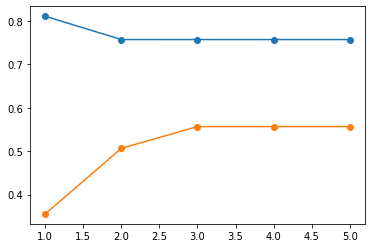

In [63]:
import matplotlib.pyplot  as plt
y=[1,2,3,4,5]
Train_Loss=plt.plot(y,train_loss,'-o',label='Train_Loss')
Training_accuracy=plt.plot(y,train_acc, '-o',label='Training_accuracy')
plt.show()